# Physical model for a wound deep piano string capable of implementing twist
The following code models the wound string as equivalent bar by utilising a discrete version cosserat rod theory.
While other models of strings as equivalent bars may yield similar results for straight bars under axial tension, the benefit of using cosserat rod theory speicifically, lies in its ability to elegenatly model bars that are anisotropic or have intrinsic twist – such as the twist historically often added to deep piano strings during the installation process.

In [1]:
%matplotlib inline

from py_wgpu_fdm import Simulation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from datetime import datetime
from scipy.spatial.transform import Rotation as R
from scipy.signal import find_peaks, sosfiltfilt, butter
from scipy.optimize import curve_fit
from scipy.io import wavfile
from IPython.display import display, Audio

## Material and geometry properties

|property|description|
|--------|-----------|
|`tuned_length`| The length of the tensioned string|
|`tension_force`| The forcing axially pulling on the string to tension it|
|`core_radius`| The radius of the core at the core of the string| 
|`winding_radius`| The radius of the wire used for the winding|
|`E_core`| The Young's modulus of the core material|
|`G_core`| The shear modulus of the core material|
|`rho_core`| The density of the core material|
|`E_winding`| The Young's modulus of the winding material|
|`G_winding`| The shear modulus of the winding material|
|`rho_winding`| The density of the winding material|
|`packing_factor`| Describes how efficiently the winding helix is covering the string|
|`mu`| The factor $\mu$ quantifies how much the winding contributes to the stiffness of the string|
|`twists`| How many twists/turns the string has post-installation (this is usually an integer)|

The `rest_length` of the string can later be determined from the stretching-stiffness $EA$ and its `tuned_length`.

In [2]:
tuned_length = 1.22 # unit: m
tension_force = 600 # unit: N
core_radius = 6.0e-4 # unit: m
winding_radius = 4.0e-4 # unit: m
E_core = 2.07e11 # unit: Pa
G_core = 8.0e10 # unit: Pa
rho_core = 7.85e3 # unit: kg/m^3
E_winding = 1.1e11 # unit: Pa
G_winding = 4.1e10 # unit: Pa
rho_winding = 8.96e3 # unit: kg/m^3
packing_factor = 0.8 # unit: 1
mu = 0.15 # unit: 1
twists = 0.0 # unit: 1

### Nodes

Discrete implementations of cosserat rod theory describe the rod's centerline as a set of discrete nodes.
Here the rod orientation is chosen, such that for a undeformed, straight rod the centerline aligns with the x axis.
The rod is discretized by `node_count` nodes.

**NB:** When choosing this spatial discretisation a common issue is that – due to the way floating point number work – most segment lenghts cannot be represented accurately. This will result in small inaccuarcies that the model interprets as intrinsic axial strain. 
However for sufficiently small spatial/time discretisations this error should be neglible.

In [3]:
node_count = 50 # unit: 1

### Edges

The nodes are connected by `node_count - 1` edges. These edges are used to represent the orientation of the material frame. 
Each orientation is represented by a unit quaternion such that applying quaternion multiplication to the the lab basis vectors $\vec{e}_1,\vec{e}_2,\vec{e}_3$ gives the director basis vectors $\vec{d}_1,\vec{d}_2,\vec{d}_3$ in lab coordinates. Here the widespread convention is adopted where $\vec{d}_3$ is parallel to the tangent vector of the centerline if there is no shear. It is pivotal that applying rotation by $q$ aligns the direction of $\vec{d}_3$ and $\vec{e_1}$ in this case! Otherwise there will be immense axial stress.

To increase numerical accuracy, the shader internals do not work with positions but rather store displacements and reference vectors.
Normally one would calculate the geomteric strain like
$$
    \vec{\sigma} = \frac{\vec{x}_{i+1} - \vec{x}_i}{\hat{l}} - \vec{d}_3.
$$
For a string this is problematic. The positions are orders of magnitude larger than their difference. Therefore constructing the difference $\vec{x}_{i+1} - \vec{x}_i$ incurrs a massive loss of precision. since floating point representation will almost never allow all node vectors as well as all difference vectors to be expressed accurately (i.e. there will always be a small *ghost* strain). The larger mantissas of the position vectors will inevitably cause non-neglibible strains that are in the same ballpark as actual displacements.
Since the string material are rather stiff, these inaccuracies are amplified into very large internal responses, which in turn inject energy into the system. 

Instead the shader essentially opts for this representation:
$$
    \vec{\sigma} = \frac{\vec{r}_{\text{rel}} + (\vec{u}_{i+1} - \vec{u}_i)}{\hat{l}} - \vec{d}_3
$$
where $\vec{r}_\text{rel}$ is the relative vector that connects nodes `i` and `i+1`. While mathematically equivalent, by storing this relative vector directly the error becomes **a lot** smaller, since the relative vector is in the order of magnitude of a single segment length where the position vectors are naturally in the order of magnitude of the string length.

Because of this the shader outputs the relative displacements. To visualize results later, the reference configuration is stored (in absolute positions) on the python side.  


**NB:** WGSL stores quaternions as `(x,y,z,w)` where w is the scalar part.

With these quantities defined, the discrete representation of the string can be generated.

In [4]:
def generate_straight_rod(
    tuned_length,
    tension_force,
    node_count,
    core_radius,
    winding_radius,
    E_core,
    G_core,
    rho_core,
    E_winding,
    G_winding,
    rho_winding,
    packing_factor,
    mu,
    twists,
):


    # Mass and Inertia
    # ----------------
    
    core_area = np.pi * core_radius**2
    A = core_area
    EA = E_core * A
    dilatation = tension_force / EA
    rest_length = tuned_length / (1 + dilatation)
    dl = rest_length / float(node_count - 1)
    
    core_mass = float(rho_core * core_area * dl)
    

    winding_area = np.pi * ( (core_radius + 2.0 * winding_radius)**2 - core_radius**2 )
    winding_mass = float(rho_winding * winding_area * dl * packing_factor)

    mass = core_mass + winding_mass

    # For circular cross sections
    # This is "lumped inertia", i.e. rho * dl * I
    I_core = rho_core * core_radius**4 / 4.0 
    I_winding = rho_winding * ((core_radius + 2.0 * winding_radius)**4 - core_radius**4) * packing_factor / 4.0 
    
    I1 = I_core + I_winding
    I3 = I1 * 2.0
    inertia = ( np.pi * dl * np.array([I1, I1, I3], dtype=np.float32))

    # Shear-Stretch and Bending-Twist stiffness (diagonal)
    # ----------------------------------------------------
    

    
    alpha = 4.0 / 3.0 # Shear correction factor for circular cross sections

    I_c = np.pi * core_radius**4 / 4.0
    J = np.pi * core_radius**4 / 2.0

    I_w = np.pi * ((core_radius + 2.0 * winding_radius)**4 - core_radius**4) * packing_factor / 4.0 

    EI = E_core * I_c + (E_winding * I_w * mu)
    
    # Shear along 1,2; axial along tangent (3)
    K_se = np.array([G_core * A * alpha, G_core * A * alpha, E_core * A], dtype=np.float32)


    # Bending about 1,2; torsion about tangent (3)
    K_bt = np.array([EI, EI, G_core * J], dtype=np.float32)


    # Geometry
    # --------
    
    x = np.linspace(0.0, tuned_length, node_count)
    reference_positions = np.stack([
        x,
        np.zeros_like(x),
        np.zeros_like(x),
    ], axis=1).astype(np.float32)



    # Edges
    # -----

    angle = np.pi / 2
    half_angle = 0.5 * angle
    q_base = np.array([0.0, np.sin(half_angle), 0.0, np.cos(half_angle)])
    
    def twist_quaternion(angle):
        half = 0.5 * angle
        return np.array([
            np.sin(half),
            0.0,         
            0.0,          
            np.cos(half)  
        ])

    
    
    def quat_mul(q1, q2):
        x1, y1, z1, w1 = q1
        x2, y2, z2, w2 = q2
    
        return np.array([
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2,
            w1*w2 - x1*x2 - y1*y2 - z1*z2
        ])

    def normalize_quat(q):
        return q / np.linalg.norm(q)

    def inv_quat(q):
        x, y, z, w = q
        return np.array([-x, -y, -z, w])
                        
    total_edges = node_count - 1
    total_angle = 2.0 * np.pi * twists
    
    orientations = []
    
    for i in range(total_edges):
        angle = total_angle * (i / total_edges)
        q_twist = twist_quaternion(angle)
    
        q = normalize_quat(quat_mul(q_twist, q_base))
        orientations.append(q)

    ref_vecs = np.array([ reference_positions[i+1] - reference_positions[i] for i in range(node_count -1) ], dtype=np.float32)
    edges = [ (o, v, np.zeros(3, dtype=np.float32), np.zeros(3, dtype=np.float32)) for o,v in zip(orientations, ref_vecs) ]
    # Ghost edge: matching the orientation of the last real segment (doesn't matter, purely for internal indexing simplification)
    edges.append((edges[-1][0], np.zeros(3, dtype=np.float32), np.zeros(3, dtype=np.float32), np.zeros(3, dtype=np.float32)))
    
    nodes = [(np.zeros(3, dtype=np.float32), np.zeros(3, dtype=np.float32), np.array([0.0, 0.0, 0.0, 1.0])) for _ in reference_positions ]
    
    print(f'Generated straight rod with a tuned length of {tuned_length}. At rest the length would be {rest_length}. This implies a dilatation factor of {dilatation}.') 

    return reference_positions, nodes, edges, dl, mass, inertia, K_se, K_bt


In [5]:
reference_positions, nodes, edges, dl, mass, inertia, K_se, K_bt = generate_straight_rod(
    tuned_length,
    tension_force,
    node_count,
    core_radius,
    winding_radius,
    E_core,
    G_core,
    rho_core,
    E_winding,
    G_winding,
    rho_winding,
    packing_factor,
    mu,
    twists
)

Generated straight rod with a tuned length of 1.22. At rest the length would be 1.2168812774482791. This implies a dilatation factor of 0.002562881531270457.


#### Sanity check: Plot intial string configuration

In [6]:
def plot_string(reference_positions, nodes, show_nodes=True):
    """
    nodes: Vec<[[x,y,z], [vx,vy,vz]]>
    """

    positions = np.array([n[0] for n in nodes])
    for i,p in enumerate(positions):
        p += reference_positions[i]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Rod centerline",
    )

    # Plot nodes
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Axis labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_title("Discretized String")
    ax.legend()

    max_range = (
        np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min(),
        ]).max() / 2.0
    )

    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()

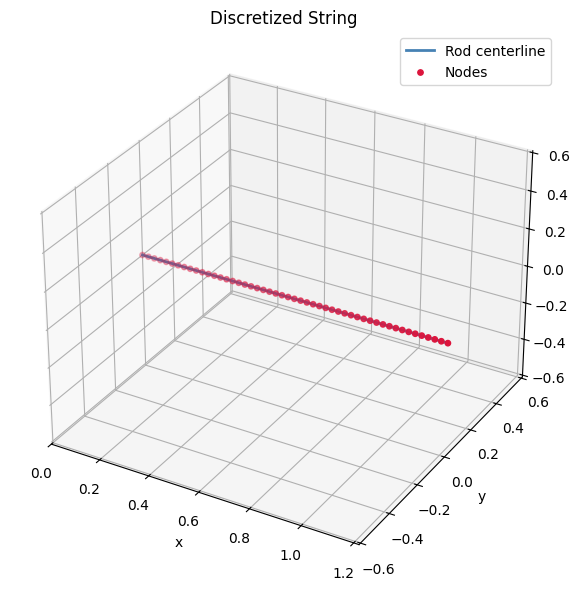

In [7]:
plot_string(reference_positions, nodes)

#### Sanity check: Plot basis vectors rotate by the material frame quaternions

Specifically *Rotated Z-axis* must sit on $(1,0,0)$ for all twists. This is because there is no shear in the initial configuration.

In [8]:
def plot_edge_quaternions(edges):
    quaternions = [ e[0] for e in edges ]

    quats = np.array(quaternions)
    norms = np.linalg.norm(quats, axis=1)
    err = [ n - 1.0 for n in norms ]
    
    plt.figure(figsize=(6,3))
    plt.plot(err, '--', label='Quaternion norm error')
    plt.xlabel('Quaternion index')
    plt.ylabel('Norm')
    plt.title('Quaternion Norm Check')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    def rotate_vector_by_quat(v, q):
        """Rotate vector v by quaternion q (x, y, z, w)"""
        x, y, z, w = q
        q_vec = np.array([x, y, z])
        return v + 2*np.cross(q_vec, np.cross(q_vec, v) + w*v)
    
    lab_axes = np.eye(3)  # x, y, z
    endpoints = { 'x': [], 'y': [], 'z': [] }
    
    for q in quats:
        for i, axis_name in enumerate(['x','y','z']):
            rotated = rotate_vector_by_quat(lab_axes[i], q)
            endpoints[axis_name].append(rotated)
    
    # Convert to arrays
    for k in endpoints:
        endpoints[k] = np.array(endpoints[k])
    
    # --- 3D plot ---
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each axis
    ax.scatter(endpoints['x'][:,0], endpoints['x'][:,1], endpoints['x'][:,2], label='Rotated X-axis')
    ax.scatter(endpoints['y'][:,0], endpoints['y'][:,1], endpoints['y'][:,2], label='Rotated Y-axis')
    ax.scatter(endpoints['z'][:,0], endpoints['z'][:,1], endpoints['z'][:,2], label='Rotated Z-axis')
    
    # Unit sphere reference
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
    xs = np.cos(u)*np.sin(v)
    ys = np.sin(u)*np.sin(v)
    zs = np.cos(v)
    ax.plot_wireframe(xs, ys, zs, color='gray', alpha=0.2)
    
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('Quaternion Frame Visualization')
    ax.legend()
    plt.show()


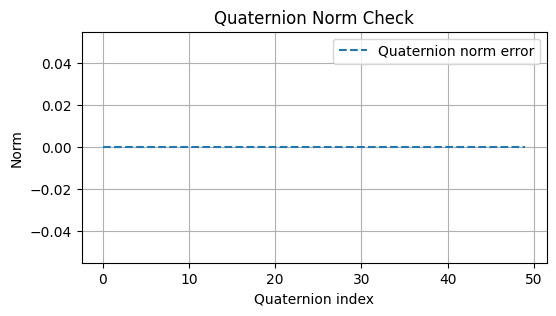

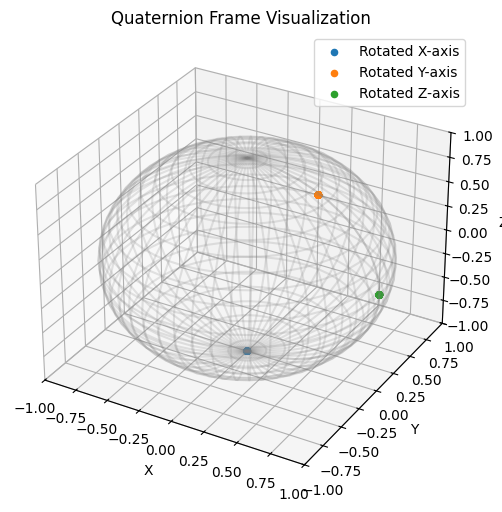

In [9]:
plot_edge_quaternions(edges)

## Time Discretization

When choosing an appropriate time-discretization it is often the case that the time-step size needed to accurately model fast moving waves (such as torsional waves in a stiff rod for example) is much smaller than what the desired `sample_rate` would demand. To aid with this, the simulation adds the `oversampling_factor` parameter. The simulation will only save the `oversampling_factor`th sample, discarding all previous ones. This process doesn't require any CPU interaction and can thus run uninhibited.

To reduce the instruction overhead caused by the memory transfer dispatches, the parmeter `chunk_size` is introduced. The simulation will keep `chunk_size` passes (frames) stored inside the GPU memory, and only trigger a transfer when the this amount is reached. 

One should bear in mind that the size of each frame depends on the amount of nodes/edges. 

In [10]:
duration = 1.0 # seconds
sample_rate = 50_000 # Hz
chunk_size = 512

dt = 2e-7 # seconds
oversampling_factor = 1.0 / (dt * sample_rate)
print(f'The appropriate oversampling factor for a target sample rate of {sample_rate} Hz at a delta t of {dt} seconds would be {oversampling_factor}.')
print(f'This yields samples that are effectively {dt * oversampling_factor} seconds apart. Therefore one chunk of {chunk_size} samples is {dt * oversampling_factor * chunk_size} seconds long.')
print(f'\nA duration of {duration} seconds would require {duration / (dt * oversampling_factor * chunk_size)} dispatches.')

if oversampling_factor.is_integer():
    oversampling_factor = int(oversampling_factor)
else:
    raise Exception("oversampling_factor must be integer value")


The appropriate oversampling factor for a target sample rate of 50000 Hz at a delta t of 2e-07 seconds would be 100.0.
This yields samples that are effectively 1.9999999999999998e-05 seconds apart. Therefore one chunk of 512 samples is 0.010239999999999999 seconds long.

A duration of 1.0 seconds would require 97.65625000000001 dispatches.


#### Choosing a dispatch count

After trying out some smaller dispatch counts and timing them out it makes sense to choose the same dispatch count for all simulations

In [11]:
dispatches = 2
print(f'{dispatches} dispatches will produces roughly {dispatches * dt * oversampling_factor * chunk_size} seconds of signal.')

2 dispatches will produces roughly 0.020479999999999998 seconds of signal.


## Dampening 

Additionally two dampening coefficients can be specified, for dampening the linear and angular accelerations respectively.
Dampening is proportional to the current velocity, e.g.
$
\vec{F}_\text{dampening}^{t+dt} = - \vec{v}^{t} * \text{linear dampening coefficient}
$

This can also be used to let configurations _settle_ by running them with a large dt (via `sim.set_dt(dt_large)`) and strong dampening coefficients, before lowering both and running the actual simulation.

In [12]:
linear_dampening = 0.000001
angular_dampening = 0.000001

dampening = [linear_dampening, angular_dampening]

## Initial conditions

To simulate a hammer strike, an external force is applied to a cluster of nodes. Internally the shader stores a read-only array that contains vectors of *weights*. These weights are multiplied by a force to allow to direct and and weaken/amplify this force per node.


**NB:** These vectors are `vec4<f32>` (even though only the first three components are needed) due to wgsl storage address space alignment constraints (though they could be optimized into a contiguous array).


The hammer strike is then created dynamically during the shader runtime.

In [13]:
def make_weights(node_count, node_index=None, width_count=4):
  
    data = np.zeros((node_count, 4), dtype=np.float32)
    x = np.arange(node_count, dtype=np.float32)
    
    sigma = width_count / 2.355
    if sigma == 0:
        sigma = 1e-5
        
    gauss_vals = np.exp(-((x - node_index)**2) / (2 * sigma**2))
    
    mask = np.abs(x - node_index) <= width_count
    data[:, 2] = gauss_vals * mask
    
    return data

In [14]:
weights = make_weights(node_count, 10, 8)


## Simulation setup

With all relevant quantities defined, the simulation instance can be initialized. The rust-side function signature is
```rust
        fn new(
            nodes: Vec<([f32; 3], [f32; 3], [f32; 4])>,
            edges: Vec<([f32; 4], [f32; 3], [f32; 3], [f32; 3])>,
            hammer_weights: Vec<[f32; 4]>,
            oversampling_factor: usize,
            chunk_size: u32,
            dt: f32,
            dx: f32,
            mass: f32,
            stiffness_se: [f32; 3],
            stiffness_bt: [f32; 3],
            inertia: [f32; 3],
            clamp_offset: u32,
            dampening: [f32; 2],
        ) -> PyResult<Self> 

```


In [15]:
sim = Simulation(
    nodes=nodes,
    edges=edges,
    hammer_weights=weights,
    oversampling_factor=oversampling_factor,
    chunk_size=chunk_size,
    dt=dt,
    dx=dl,
    mass=mass,
    stiffness_se = K_se,
    stiffness_bt = K_bt,
    inertia=inertia,
    clamp_offset=0,
    dampening=dampening
)
 

### Initializing the simulation
Calling the `initialize` method to set up some shader internals.
(This used to set reference strains, but they are now determined during the geometry creation and passed to the shader via the Simulation constructor)

In [16]:
sim.initialize()

Initializing simulation!


### Simulating a hammer strike

While it may seem tempting to model the hammer strike as a pure and instantaneous velocity impulse this disregards the fact that the hammer is in contact with the string for a while. Thus an approach is chosen where for a small time window an external force is applied. This can be done by calling the 
```rust
hammer(steps, force)
```
method on the simulation instance. The function below creates a force force roughly resembling this graph, though any arbitrary force curve can be chosen here.

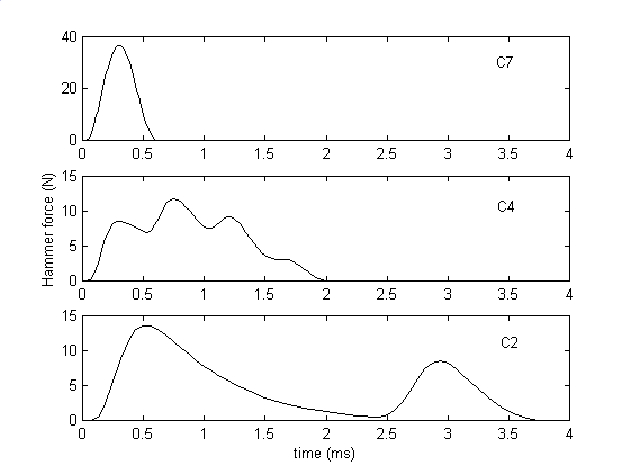

In [17]:
def make_force_curve(dt, duration):
    scale = duration / 4.0
    t = np.arange(0, duration, dt)
    
    mu1 = 0.50 * scale
    amp1 = 15.0
    sig1_left = 0.1 * scale
    sig1_right = 0.75 * scale
    
    mu2 = 3 * scale
    amp2 = 8.5
    sig2 = 0.2 * scale
    
    force = np.zeros_like(t)
    
    mask_left = t <= mu1
    force[mask_left] += amp1 * np.exp(-0.5 * ((t[mask_left] - mu1) / sig1_left)**2)
    force[~mask_left] += amp1 * np.exp(-0.5 * ((t[~mask_left] - mu1) / sig1_right)**2)
    
    force += amp2 * np.exp(-0.5 * ((t - mu2) / sig2)**2)
    
    return t, force

In [18]:
_, force = make_force_curve(dt, 0.004)


Now this can be applied to the simulation (which is currently at rest). To reduce overhead a bit we can downsample the force curve beforehand:

In [19]:
ds_force = force[::10]

for f in ds_force:
    sim.hammer(10, f)

## Running the simulation
`node_frames` and `edge_frames` will be used to collect the respective frame data. 
To run the simulation, first the `compute` method is called, which runs `chunk_size * oversampling_factor` simulation loops.

Then the `save` method facilitates the transfer to the CPU staging buffer, eventually making the data available to python.

In [20]:
%%time

node_frames = list()
edge_frames = list()

for i in range(dispatches):
    sim.compute()
    n, e = sim.save()
    node_frames.extend(n)
    edge_frames.extend(e)

CPU times: user 50.3 s, sys: 17.1 s, total: 1min 7s
Wall time: 46.2 s


#### Sanity check: Are any displacements NaN?
Checking the last frame is sufficient.

In [21]:
if any(np.isnan(node[0]).any() for node in node_frames[-1]):
    print("Some displacements are NaN; the dt is likely too small for the chosen dl!")
else:
    print("No NaNs found!")


No NaNs found!


#### Sanity check: Plot string displacements
This is probably not too exciting since the expected displacement are most likely very small. However this plot can make it easy to spot if the rod isn't oscillating around its minimal energy configuration.

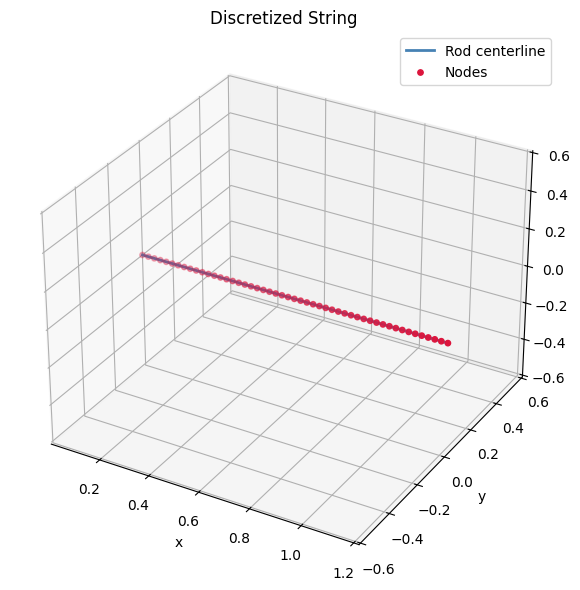

In [32]:
plot_string(reference_positions, node_frames[-1])

## Results

### Displacement over time & FFTs
To get a sense for the oscillations happening inside the string, as well as the frequency spectra, plots are created to visualtion the evolution of the different displacement directions. These signals are then Fourier-Transformed. This also tries to detected peaks and fit an inharmonicity curve, though this needs further refinement.

In [33]:
def plot_node_pos_vel_moment_fft(
    nodes_history,
    dt,
    oversampling_factor,
    cutoff=20_000,
    node_index=None,
    moments=False,
    save_output=False,
    windowing=False,
    fundamental_weight=0.2,
    prefix="unknown",
):
    T = len(nodes_history)
    N = len(nodes_history[0])

    if node_index is None:
        node_index = N // 2

    time = np.arange(T) * dt * oversampling_factor
    freqs = np.fft.rfftfreq(T, dt * oversampling_factor)

    pos = np.zeros((T, 3), dtype=np.float32)
    vel = np.zeros((T, 3), dtype=np.float32)
    mom = np.zeros((T, 3), dtype=np.float32)

    for t in range(T):
        p, v, m, _ = nodes_history[t][node_index]
        pos[t] = p
        vel[t] = v
        mom[t] = m

    components = [
        ("x", pos[:, 0], vel[:, 0], mom[:, 0]),
        ("y", pos[:, 1], vel[:, 1], mom[:, 1]),
        ("z", pos[:, 2], vel[:, 2], mom[:, 2]),
    ]

    def fft_mag(signal):
        sig = signal - np.mean(signal)
        if windowing:
            window = np.hanning(len(sig))
            sig = sig * window
        fft = np.fft.rfft(sig)
        return np.abs(fft)

    def stiff_string_model(n, f1_val, B_val):
        return n * f1_val * np.sqrt(1 + B_val * (n**2))

    for label, p_data, v_data, m_data in components:
        n_plots = 3 + int(moments)
        fig, axes = plt.subplots(
            n_plots, 1,
            figsize=(10, 2.8 * n_plots),
            sharex=False,
        )

        ax = axes[0]
        p_max = np.max(np.abs(p_data))
        v_max = np.max(np.abs(v_data))

        p_scaled = p_data / p_max if p_max > 0 else p_data
        v_scaled = v_data / v_max if v_max > 0 else v_data

        ax.plot(time, p_scaled, color="tab:blue")
        ax.set_ylim(-1.05, 1.05)
        ax.set_ylabel(f"{label} disp", color="tab:blue")
        ax.tick_params(axis="y", labelcolor="tab:blue")
        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([f"{-p_max:.3e}", "0", f"{p_max:.3e}"])

        ax2 = ax.twinx()
        ax2.plot(time, v_scaled, "--", color="tab:orange")
        ax2.set_ylim(-1.05, 1.05)
        ax2.set_ylabel(f"{label} vel", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        ax2.set_yticks([-1, 0, 1])
        ax2.set_yticklabels([f"{-v_max:.3e}", "0", f"{v_max:.3e}"])
        ax.set_title(f"{label} — displacement & velocity (time)")
        ax.grid(True, alpha=0.3)

        plot_idx = 1
        if moments:
            axm = axes[plot_idx]
            m_max = np.max(np.abs(m_data))
            m_scaled = m_data / m_max if m_max > 0 else m_data

            axm.plot(time, m_scaled, color="tab:green")
            axm.set_ylim(-1.05, 1.05)
            axm.set_ylabel(f"{label} moment")
            axm.set_yticks([-1, 0, 1])
            axm.set_yticklabels([f"{-m_max:.3e}", "0", f"{m_max:.3e}"])
            axm.set_title(f"{label} — moment (time)")
            axm.grid(True, alpha=0.3)
            plot_idx += 1

        bins = fft_mag(p_data)
        axf = axes[plot_idx]
        axf.plot(freqs, bins, color="tab:blue")
        axf.set_ylabel("FFT |disp|")
        axf.set_title(f"{label} — displacement FFT")
        axf.set_xlim(0, cutoff)
        axf.grid(True, alpha=0.3)
        plot_idx += 1

        ax_fit = axes[plot_idx]
        mag_norm = bins / np.max(bins) if np.max(bins) > 0 else bins
        
        # Use a relative height threshold to avoid fitting noise floor
        peak_indices, _ = find_peaks(mag_norm, height=0.02, distance=5)
        peak_freqs = freqs[peak_indices]
        peak_mags = mag_norm[peak_indices]

        if len(peak_freqs) >= 2:
            significant_peaks_indices = np.where(peak_mags > fundamental_weight)[0]
            if len(significant_peaks_indices) > 0:
                f1_est = peak_freqs[significant_peaks_indices[0]]
            else:
                f1_est = peak_freqs[np.argmax(peak_mags)]

            measured_partials = []
            harmonic_indices = []
            
            search_tolerance = 0.45 * f1_est 
            consecutive_misses = 0

            for n in range(1, 20):
                if consecutive_misses > 2:
                    break

                target = n * f1_est
                idx_closest = np.argmin(np.abs(peak_freqs - target))
                closest_freq = peak_freqs[idx_closest]
                
                # Check tolerance
                if np.abs(closest_freq - target) < search_tolerance:
                    measured_partials.append(closest_freq)
                    harmonic_indices.append(n)
                    consecutive_misses = 0
                else:
                    consecutive_misses += 1

            ns = np.array(harmonic_indices)
            fns = np.array(measured_partials)

            f1_fit, B_fit = f1_est, 0.0
            
            if len(ns) >= 4:
                try:
                    popt, pcov = curve_fit(stiff_string_model, ns, fns, p0=[f1_est, 0.0001])
                    f1_fit, B_fit = popt
                except RuntimeError:
                    pass
            
            ax_fit.plot(freqs, mag_norm, color='lightgray', label='Spectrum')
            ax_fit.plot(peak_freqs, peak_mags, 'x', color='tab:blue', label='Detected Peaks')

            fitted_freqs = stiff_string_model(ns, f1_fit, B_fit)
            
            if len(fitted_freqs) > 0:
                ax_fit.scatter(fitted_freqs, np.interp(fitted_freqs, freqs, mag_norm), 
                               color='tab:red', zorder=5, label=f'Fit (B={B_fit:.2e})')

            ideal_freqs = ns * f1_fit
            for f_ideal in ideal_freqs:
                ax_fit.axvline(f_ideal, color='green', linestyle=':', alpha=0.5)

            ax_fit.set_xlim(0, cutoff) 
            if len(fns) > 0:
                 ax_fit.set_xlim(0, max(fns) * 1.2)
                 
            ax_fit.set_title(f"{label} — Inharmonicity Fit (B = {B_fit:.5f})")
            ax_fit.set_xlabel("Frequency [Hz]")
            ax_fit.legend(loc='upper right', fontsize='small')
            
            print(f"{label} Inharmonicity Coeff (B): {B_fit:.2e}")

        else:
            ax_fit.text(0.5, 0.5, "Not enough peaks for fit", 
                        ha='center', va='center', transform=ax_fit.transAxes)
            ax_fit.set_title(f"{label} — Inharmonicity Fit")

        ax_fit.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_output:
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            filename = f"{timestamp}_{prefix}-{label}.png"
            plt.savefig(filename, dpi=300, bbox_inches="tight")

        plt.show()

x Inharmonicity Coeff (B): 0.00e+00


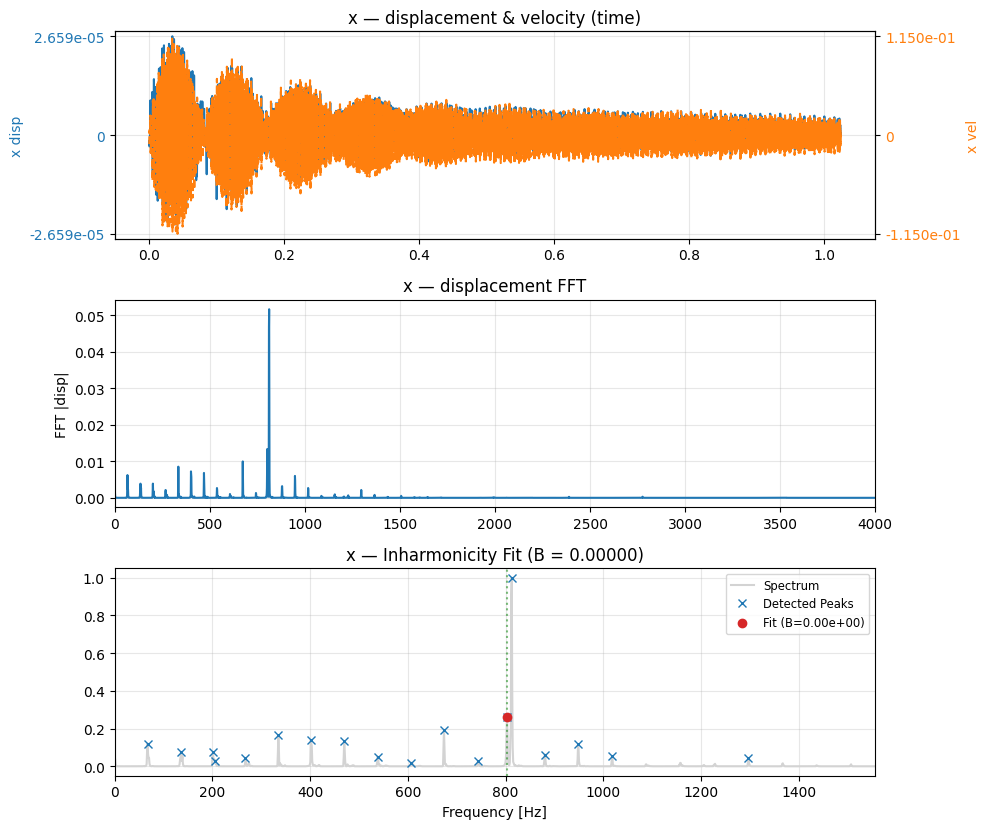

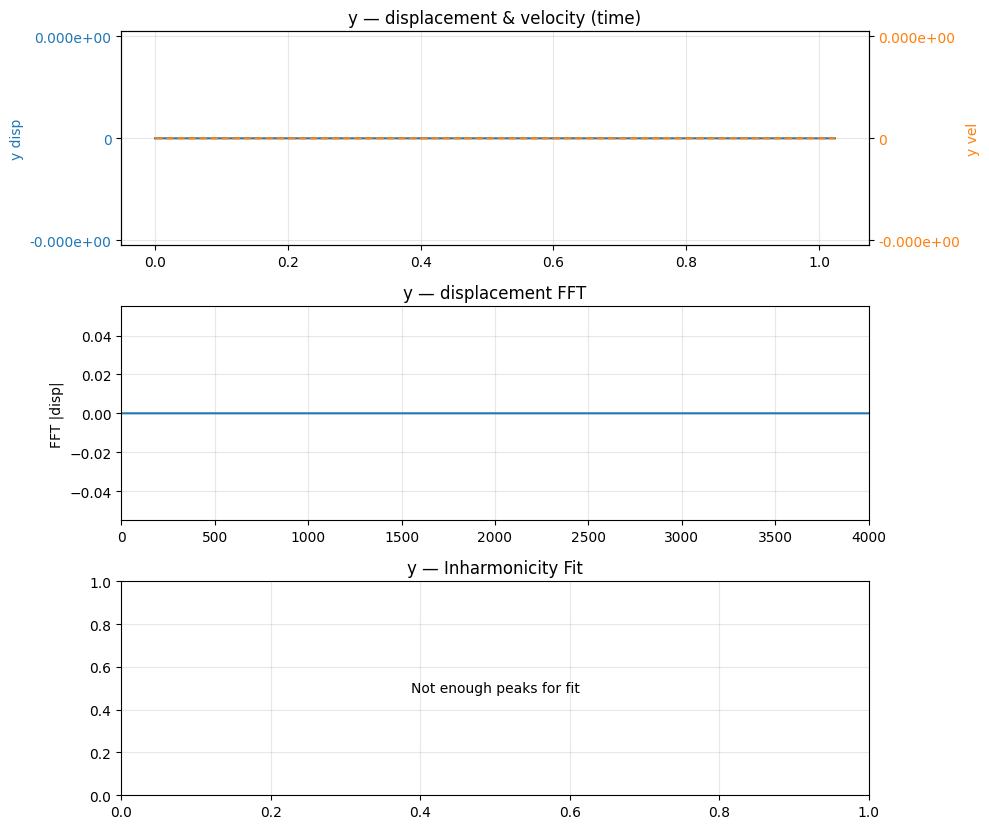

z Inharmonicity Coeff (B): 2.77e-04


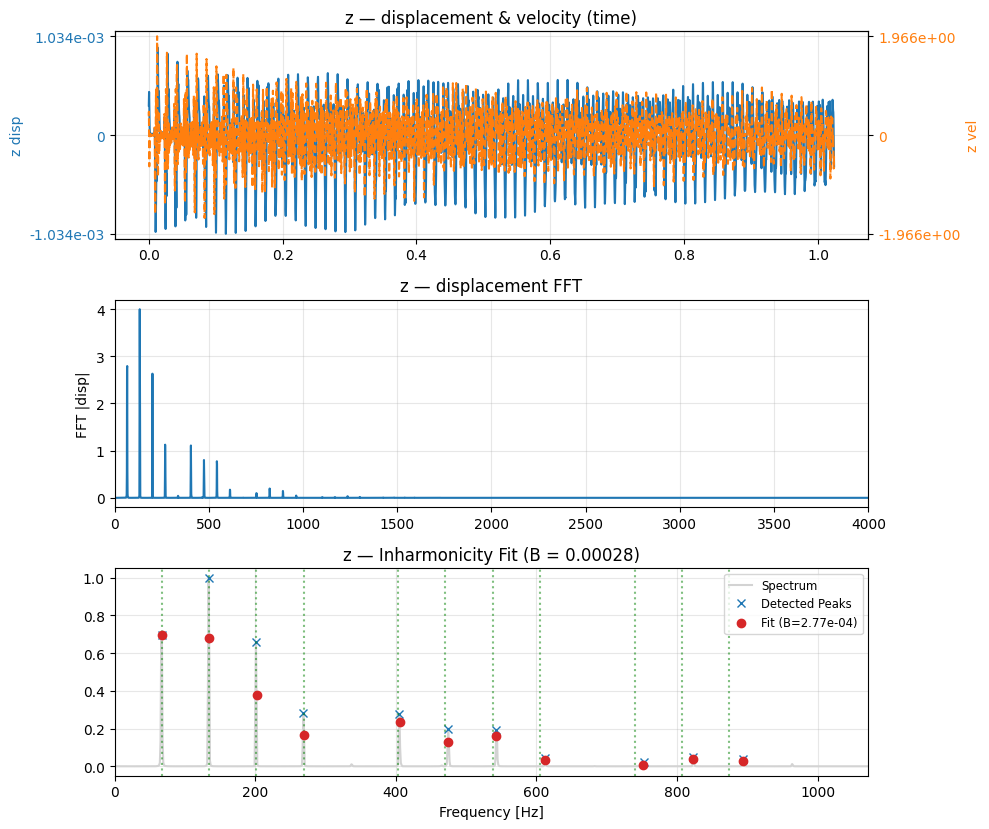

In [34]:
plot_node_pos_vel_moment_fft(node_frames, dt, oversampling_factor, cutoff=4000, windowing=True, node_index=20, prefix="no_twists")

### Materialframe orientations

The material frame orientations are represented by unit quaternions, which aren't especially intuitive. Hence, they are transformed to an axis/angle representation to offer a slightly more intuitive visualization of rotation. In some cases disregarding one of the axis components (because it is virtually unmoved) can lead to a more insteresting plot. 

In [35]:

def plot_axis_angle_over_time(frames, node_index, components="xyz", save_output=False, prefix="unknown"):
    axes = []
    angles = []

    for frame_idx, frame in enumerate(frames):
        if node_index >= len(frame):
            raise IndexError(f"Node index {node_index} out of range in frame {frame_idx}")

        quat = np.array(frame[node_index][0], dtype=float)

        quat /= np.linalg.norm(quat)

        rot = R.from_quat(quat)  # (x, y, z, w)

        rotvec = rot.as_rotvec()

        angle = np.linalg.norm(rotvec)

        if angle > 1e-8:
            axis = rotvec / angle
        else:
            axis = np.array([0.0, 0.0, 0.0])

        axes.append(axis)
        angles.append(angle)

    axes = np.array(axes)
    angles = np.array(angles)

    t = np.arange(len(frames))

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

    ax1.plot(t, np.degrees(angles))
    ax1.set_ylabel("Angle (degrees)")
    ax1.set_title(f"Axis–Angle orientation over time (node {node_index})")
    ax1.grid(True)

    if 'x' in components: ax2.plot(t, axes[:, 0], label="Axis X")
    if 'y' in components: ax2.plot(t, axes[:, 1], label="Axis Y")
    if 'z' in components: ax2.plot(t, axes[:, 2], label="Axis Z")
    ax2.set_xlabel("Frame")
    ax2.set_ylabel("Axis component")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    if save_output:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"{timestamp}_{prefix}-angles.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


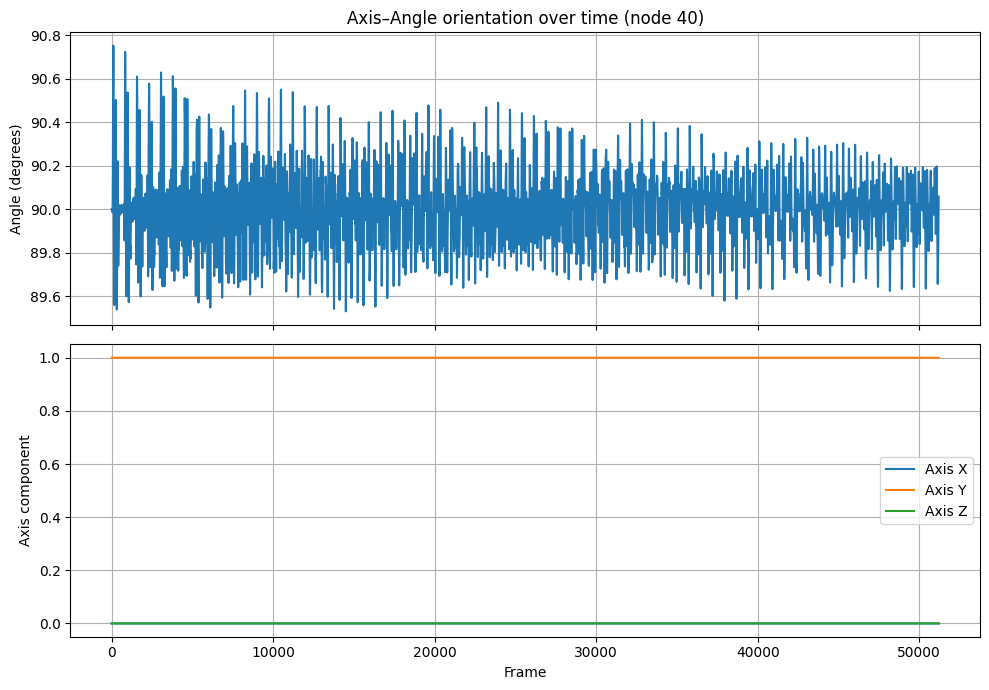

In [36]:
plot_axis_angle_over_time(edge_frames, node_index=40, components="xyz", save_output=True, prefix="no_twists")

### Energies

It may also be insightful to watch how the energy distribution of the system evolves over time. In general the system can show two kinds of kinetic energies (rotational and translation) and two kinds of potential energies (bend/twist and shear/stretch). If the string is tensioned a substantial amount of potential energy in innately present in the system. To condense the plot and more accurately display energy-exchange the parameter `remove_offset` will subtract the initial potential energy from the history. 

**NB:** to accurate remove the potential energy caused by tension and twsit one needs to simulate the system at rest and subtract those values. The `remove_offset` parameter is solely used to build intuition, but usually does a pretty good job. Also note that `scipy.signal.detrend` doesn't play nicely with numerical dampening, so instead a simple highpass filter is used.

In [37]:
def E_T(node, mass):
    velocity = np.array(node[1])
    return 0.5 * mass * np.dot(velocity, velocity)

def E_R(omega_vec, inertia):
    w = np.array(omega_vec)
    I = np.array(inertia)
    if I.ndim == 1: 
        return 0.5 * np.dot(w, I * w)
    return 0.5 * np.dot(w, np.dot(I, w))

def E_PB(kappa, K_bt):
    k = np.array(kappa)
    K = np.array(K_bt)
    return 0.5 * np.dot(k, K * k)

def E_PS(strain, K_se):
    s = np.array(strain)
    k = np.array(K_se)
    return 0.5 * np.dot(s, k * s)

def plot_energies(nodes_frames, edges_frames, m_node, inertia, K_se, K_bt, dl, show_totals=True, remove_offset=False, save_output=False, prefix="unknown"):
    trans_ke = []
    rot_ke = []
    bend_twist_pe = []
    shear_stretch_pe = []
    
    for i in range(len(nodes_frames)):
        t_sum = 0
        bt_sum = 0
        for j, node in enumerate(nodes_frames[i]):
            weight = 0.5 if (j == 0 or j == len(nodes_frames[i])-1) else 1.0
            
            t_sum += E_T(node, m_node) * weight
            bt_sum += E_PB(node[2], K_bt) * weight
            
        trans_ke.append(t_sum)
        bend_twist_pe.append(bt_sum)
        
        r_sum = 0
        ss_sum = 0
        for edge in edges_frames[i]:
            r_sum += E_R(edge[1][0], inertia)
            ss_sum += E_PS(edge[1][2], K_se)

        rot_ke.append(r_sum)
        shear_stretch_pe.append(ss_sum)
    
    trans_ke = np.array(trans_ke)
    rot_ke = np.array(rot_ke)
    bend_pe = np.array(bend_twist_pe) * dl
    shear_pe = np.array(shear_stretch_pe) * dl

    if remove_offset:
        sos = butter(4, 0.01, btype='high', output='sos')
        trans_ke = sosfiltfilt(sos, trans_ke)
        rot_ke = sosfiltfilt(sos, rot_ke)
        bend_pe = sosfiltfilt(sos, bend_pe)
        shear_pe = sosfiltfilt(sos, shear_pe)

    total_kin = trans_ke + rot_ke
    total_pot = bend_pe + shear_pe
    total_energy = total_kin + total_pot

    plt.figure(figsize=(12, 8))
    
    plt.plot(trans_ke, label="Translational KE", alpha=0.4, linestyle=':')
    plt.plot(rot_ke, label="Rotational KE", alpha=0.4, linestyle=':')
    plt.plot(bend_pe, label="Potential: Bend/Twist", alpha=0.4, linestyle=':')
    plt.plot(shear_pe, label="Potential: Shear/Stretch", alpha=0.4, linestyle=':')
    if show_totals:
        plt.plot(total_kin, label="TOTAL Kinetic Energy", linewidth=2, color='blue')
        plt.plot(total_pot, label="TOTAL Potential Energy", linewidth=2, color='orange')
        if not remove_offset: 
            plt.plot(total_energy, label="TOTAL SYSTEM ENERGY", color='black', linestyle='--', linewidth=1.5)
    
    plt.title("Cosserat Rod Energy Breakdown")
    plt.ylabel("Energy (Joules)")
    plt.xlabel("Frame Index")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_output:        
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"{timestamp}_{prefix}-{prefix}-energy.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        
    plt.show()

    print(f"Total Energy Mean: {np.mean(total_energy):.6e} J")
    print(f"Energy Variation: {np.std(total_energy):.6e} J")

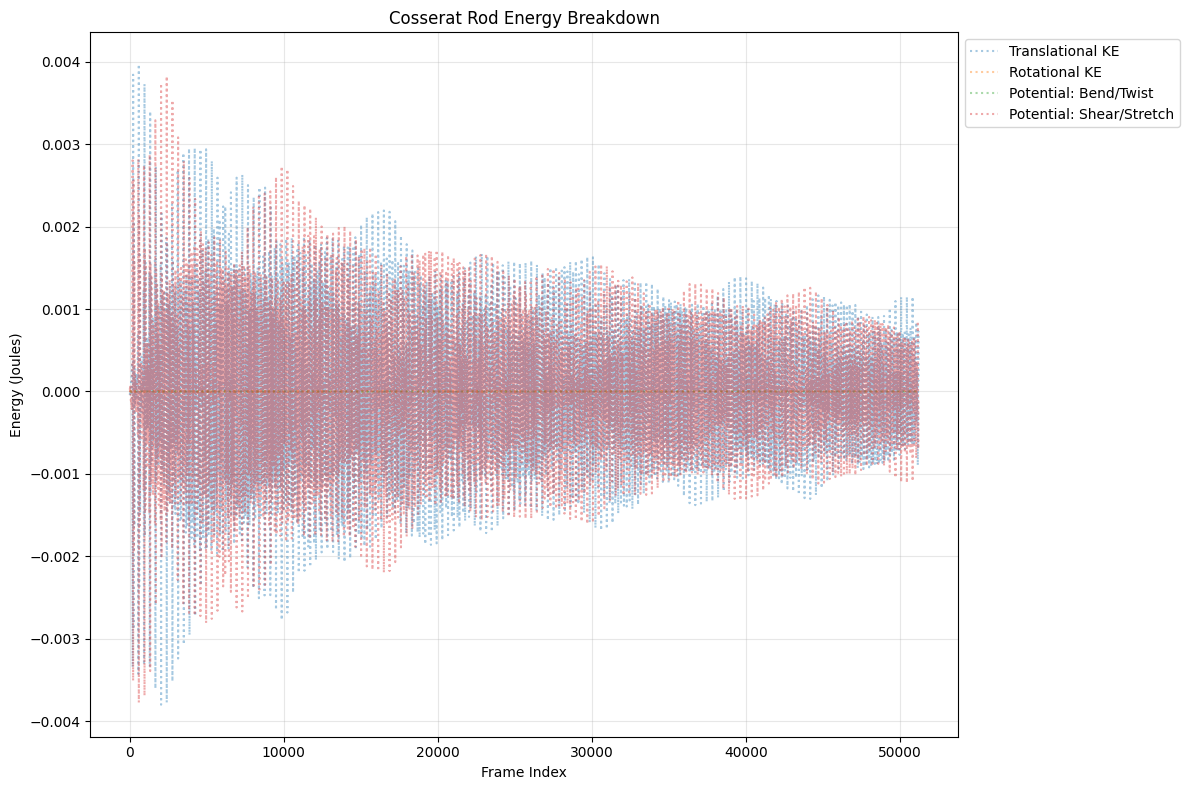

Total Energy Mean: 3.359302e-09 J
Energy Variation: 9.568334e-05 J


In [38]:
start, end = (0, len(node_frames))
plot_energies(node_frames[start:end], edge_frames[start:end], mass, inertia, K_se, K_bt, dl, show_totals=False, remove_offset=True, save_output=True, prefix="no_twists")

### Audio

Finally, the displacements can be played back as audio. The function below extracs both transversal vibrations as stereo signal (`y -> left ear` and `z -> right ear`).

**NB:** For an untwisted string that was excited purely into one (`z`) direction, the other channel should be empty.

In [42]:
def play_node_audio(frames, sample_rate, node_index=None, save_output=False, prefix="unknown"):
    node_index = len(frames[0]) // 2 if node_index is None else node_index
    
    y_displacement = np.array([frame[node_index][0][1] for frame in frames])
    z_displacement = np.array([frame[node_index][0][2] for frame in frames])
    
    stereo_data = [y_displacement, z_displacement]

    if save_output and (len(frames) / sample_rate) < 0.2:
        print("Output is less than 0.5 seconds long, omitting saving output")
        save_output = False
    if save_output:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"{timestamp}_{prefix}-audio.wav"
        
        wav_data = np.column_stack((y_displacement, z_displacement))
        
        max_amp = np.max(np.abs(wav_data))
        if max_amp > 0:
            wav_data = wav_data / max_amp
            
        wav_data = np.float32(wav_data)
        
        wavfile.write(filename, sample_rate, wav_data)
    
    display(Audio(data=stereo_data, rate=sample_rate))

In [43]:
play_node_audio(node_frames, sample_rate, save_output=True, prefix="no_twists")

# Adding a single twist
By having set up a solid set of tools for simulation and visualisation, the string can easily be simulated again but this time one twist is added to replicate common real-world installation setups. Just as before we set up and initialize the simulation and run it

## Simulation setup

In [25]:
reference_positions, nodes, edges, dl, mass, inertia, K_se, K_bt = generate_straight_rod(
    tuned_length,
    tension_force,
    node_count,
    core_radius,
    winding_radius,
    E_core,
    G_core,
    rho_core,
    E_winding,
    G_winding,
    rho_winding,
    packing_factor,
    mu,
    twists=1.0
)

Generated straight rod with a tuned length of 1.22. At rest the length would be 1.2168812774482791. This implies a dilatation factor of 0.002562881531270457.


#### Sanity checks

Just like before the usual checks are performed to catch ill conditioned geometry.

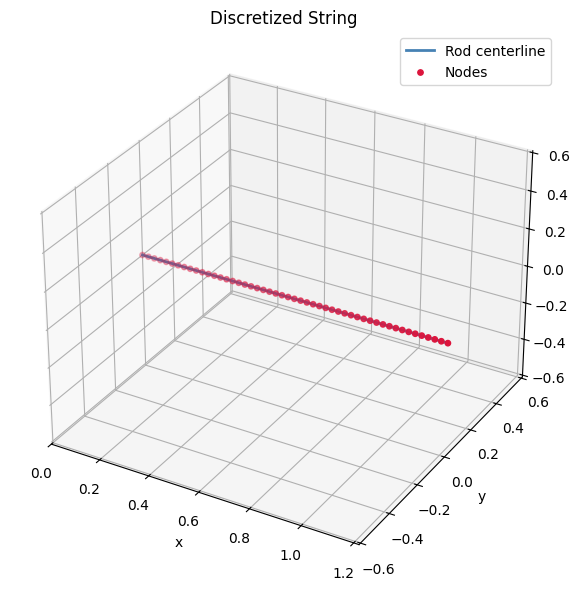

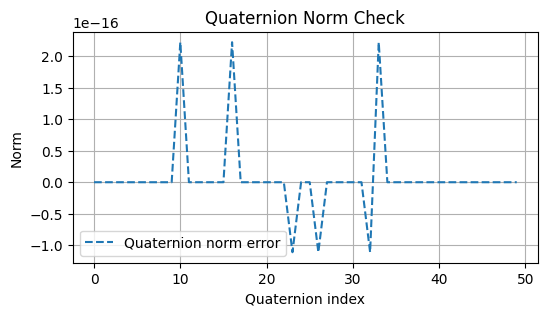

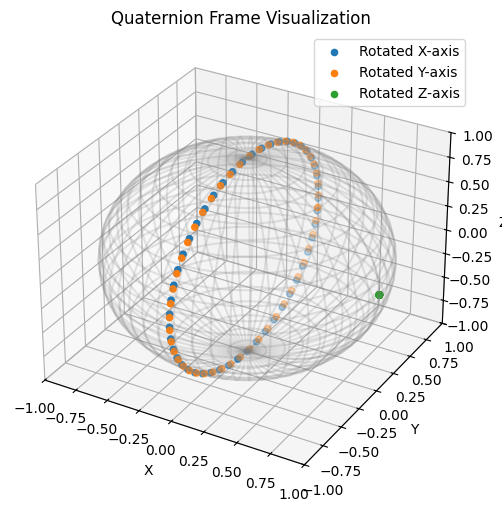

In [26]:
plot_string(reference_positions, nodes)
plot_edge_quaternions(edges)

In [27]:
sim = Simulation(
    nodes=nodes,
    edges=edges,
    hammer_weights=weights,
    oversampling_factor=oversampling_factor,
    chunk_size=chunk_size,
    dt=dt,
    dx=dl,
    mass=mass,
    stiffness_se = K_se,
    stiffness_bt = K_bt,
    inertia=inertia,
    clamp_offset=0,
    dampening=dampening,
)
 

sim.initialize()

Initializing simulation!


## Initial conditions

Same as earlier.

In [28]:
for f in ds_force:
    sim.hammer(10, f)

## Running the simulation

In [29]:
%%time

tnode_frames = list()
tedge_frames = list()

for i in range(dispatches):
    sim.compute()
    n, e = sim.save()
    tnode_frames.extend(n)
    tedge_frames.extend(e)

CPU times: user 34min 5s, sys: 12min 27s, total: 46min 32s
Wall time: 30min 20s


#### Sanity checks

No NaNs found!


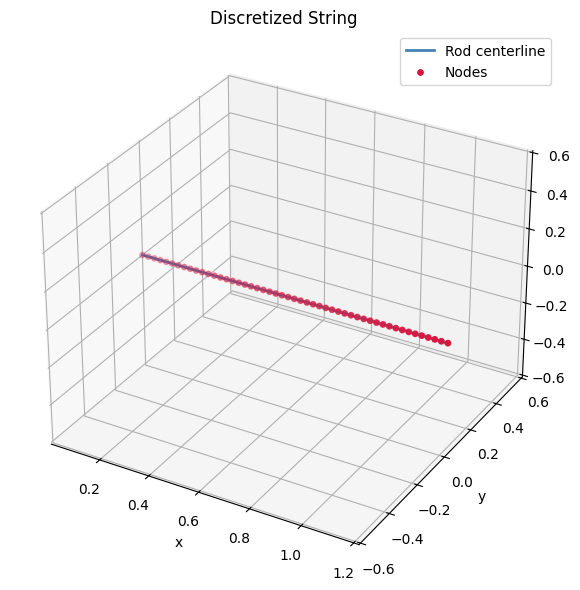

In [30]:
if any(np.isnan(node[0]).any() for node in tnode_frames[-1]):
    print("Some displacements are NaN; the dt is likely too small for the chosen dl!")
else:
    print("No NaNs found!")
    plot_string(reference_positions, tnode_frames[-1])



## Results

Using the functions from above, results are visualized.

x Inharmonicity Coeff (B): 0.00e+00


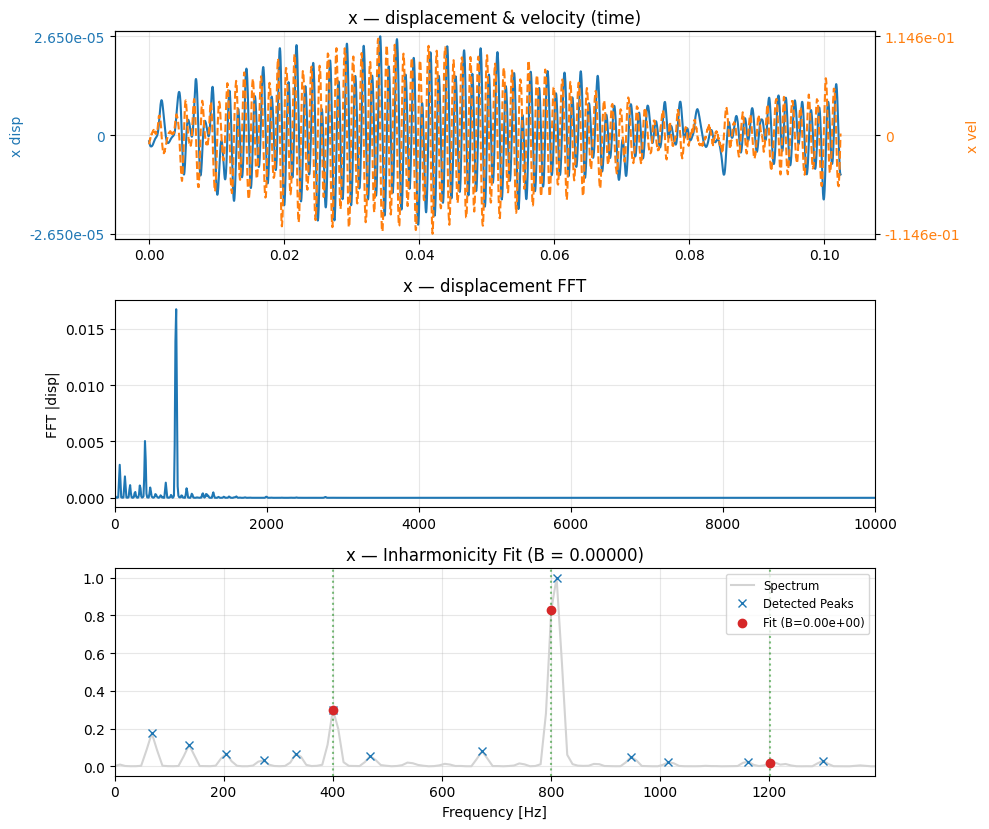

y Inharmonicity Coeff (B): 3.85e-05


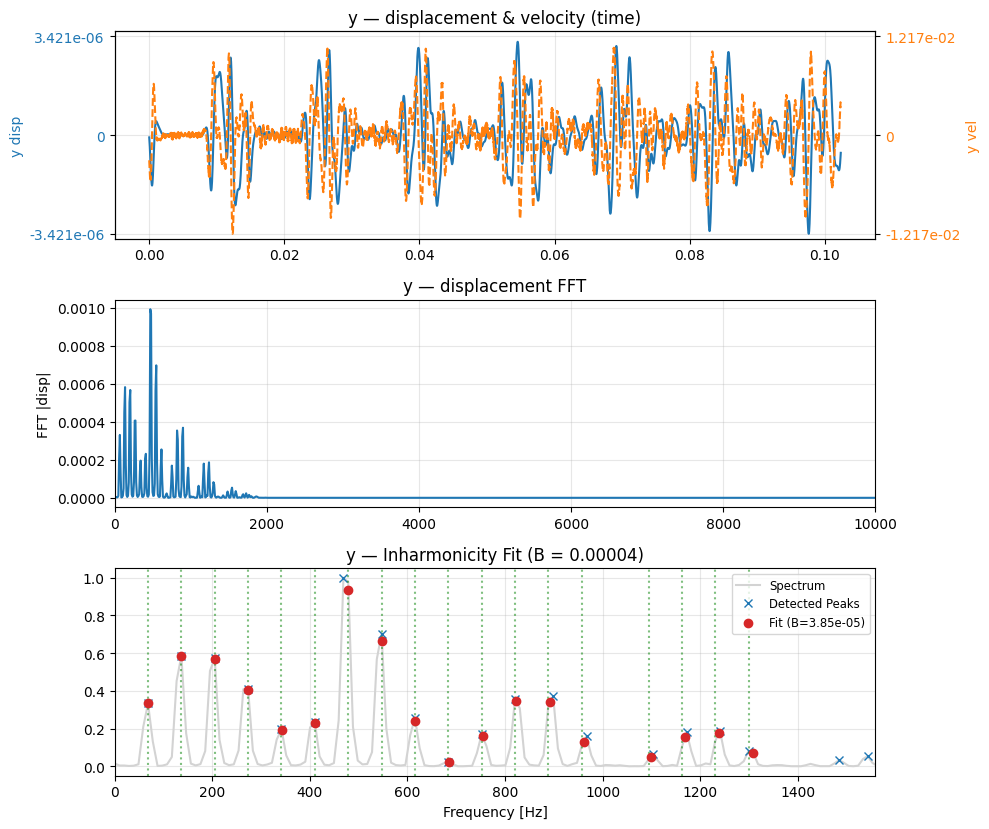

z Inharmonicity Coeff (B): 1.28e-04


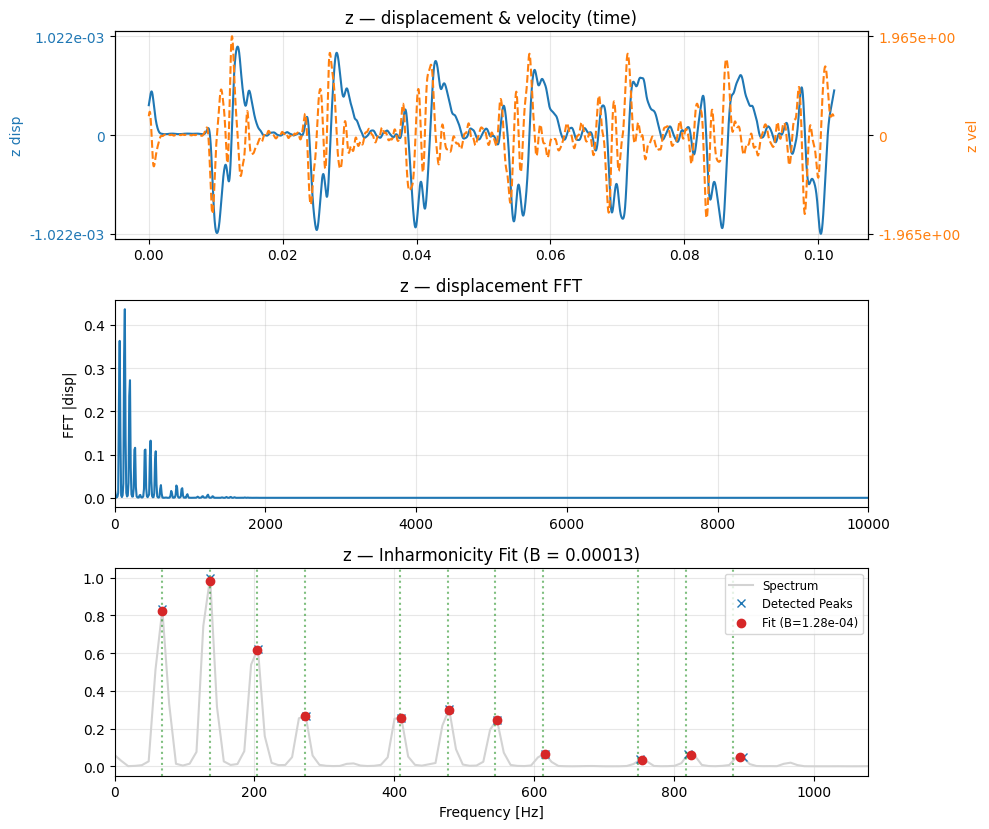

In [41]:
plot_node_pos_vel_moment_fft(tnode_frames, dt, oversampling_factor, cutoff=10000, windowing=True, node_index=20, save_output=True, prefix="one_twist")

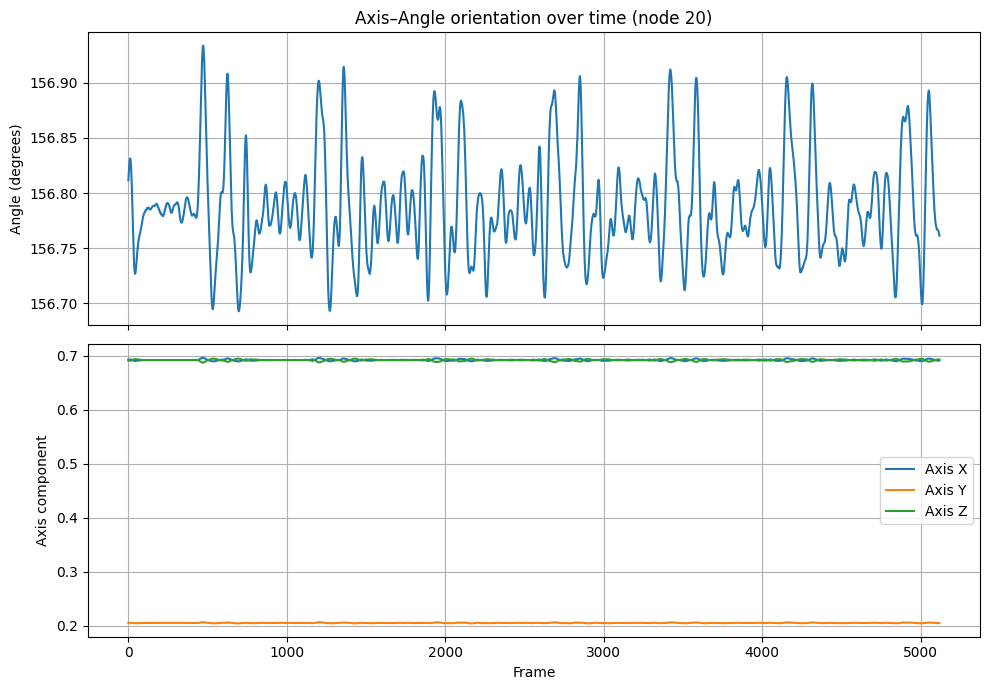

In [44]:
plot_axis_angle_over_time(tedge_frames, node_index=20, components="xyz")

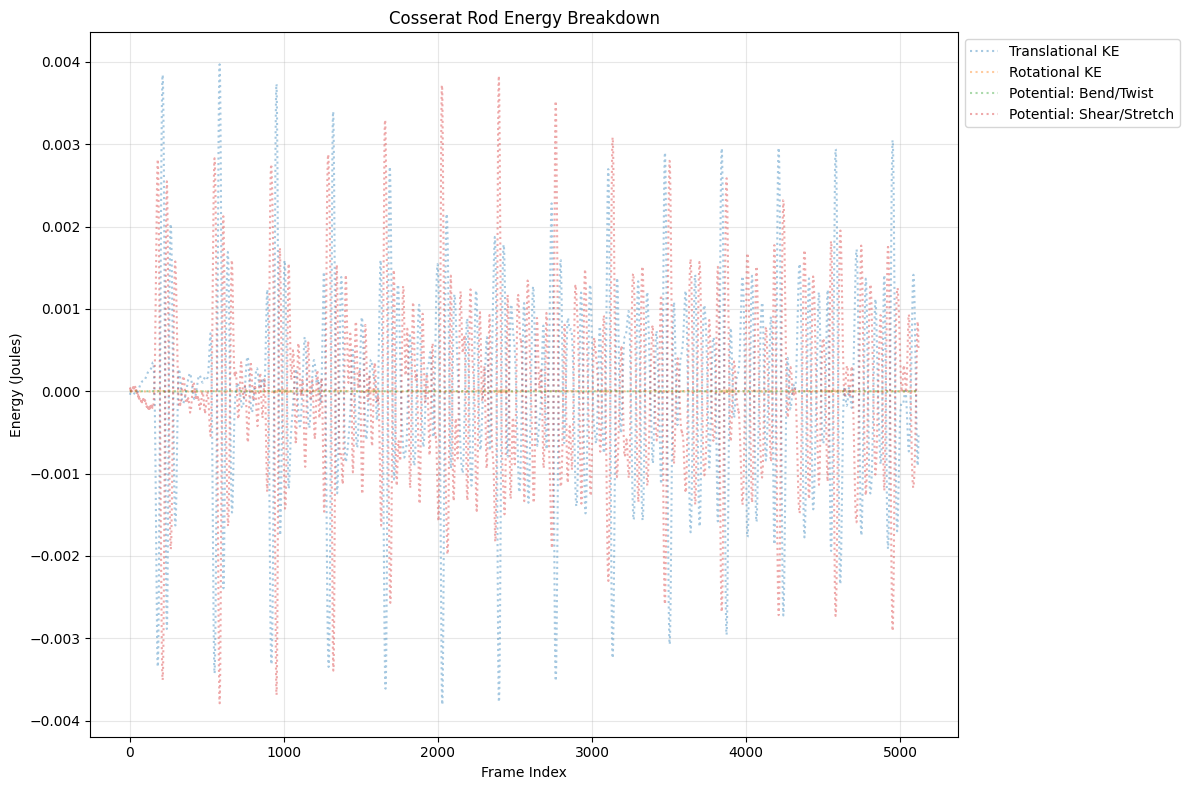

Total Energy Mean: 7.827495e-08 J
Energy Variation: 2.268717e-04 J


In [45]:
start, end = (0, len(node_frames))
plot_energies(tnode_frames[start:end], tedge_frames[start:end], mass, inertia, K_se, K_bt, dl, show_totals=False, remove_offset=True)

In [46]:
play_node_audio(tnode_frames, sample_rate, save_output=True, prefix="one_twist")

Output is less than 0.5 seconds long, omitting saving output


### Comparing kinetic energy

Now that there's data for the two different systems one can compare the results.
Notably the time-evolution of the kinetic energy appears identical, even though the twist introduces complex coupling nonlinearities.

In [47]:
def E_T(node, mass):
    velocity = np.array(node[1])
    return 0.5 * mass * (velocity @ velocity)

def compare_T_yz(node_frames, tnode_frames, m_node, save_output=False, prefix="unknown"):
    n_trans_yz = []
    tn_trans_yz = []
    rot_ke = []
    trot_ke = []
    
    for i in range(len(node_frames)):
        t_sum = 0
        tt_sum = 0
        for (node, tnode) in zip(node_frames[i], tnode_frames[i]):
            t_sum += E_T(node, m_node)
            tt_sum += E_T(tnode, m_node)
            
        n_trans_yz.append(t_sum)
        tn_trans_yz.append(tt_sum)

    for i in range(len(edge_frames)):
        r_sum = 0
        tr_sum = 0
        for (edge, tedge) in zip(edge_frames[i], tedge_frames[i]):
            r_sum += E_R(edge[1][0], inertia)
            tr_sum += E_R(tedge[1][0], inertia)

        rot_ke.append(r_sum)
        trot_ke.append(tr_sum)
   
    n_trans_yz = np.array(n_trans_yz)
    tn_trans_yz = np.array(tn_trans_yz)
    rot_ke = np.array(rot_ke)
    trot_ke = np.array(trot_ke)
    
    plt.plot(n_trans_yz, label="Configuration A", linestyle='-')
    plt.plot(tn_trans_yz, label="Configuration B", linestyle='--')
    plt.title("Kinetic Energy in Transversal Motions")
    plt.ylabel("Energy (Joules)")
    plt.xlabel("Frame Index")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    if save_output:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"{timestamp}-{prefix}_energy_comparison.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        
    plt.show()

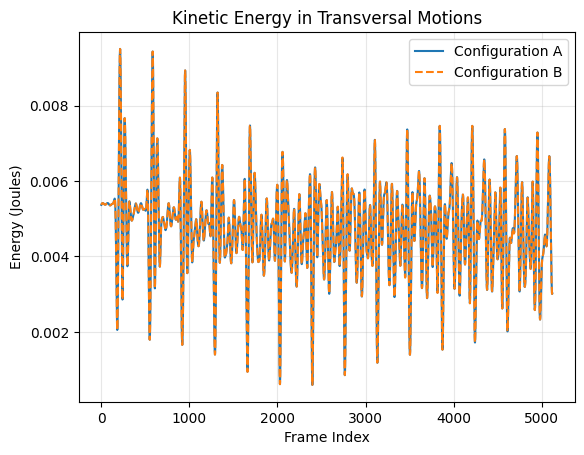

In [48]:
compare_T_yz(node_frames, tnode_frames, mass, save_output=True, prefix="no_and_one_twist")

# Adding three twists

Same as before, except this time the string undergoes three full twists.

## Simulation setup

In [49]:
reference_positions, nodes, edges, dl, mass, inertia, K_se, K_bt = generate_straight_rod(
    tuned_length,
    tension_force,
    node_count,
    core_radius,
    winding_radius,
    E_core,
    G_core,
    rho_core,
    E_winding,
    G_winding,
    rho_winding,
    packing_factor,
    mu,
    twists=3.0
)

Generated straight rod with a tuned length of 1.22. At rest the length would be 1.2168812774482791. This implies a dilatation factor of 0.002562881531270457.


#### Sanity checks

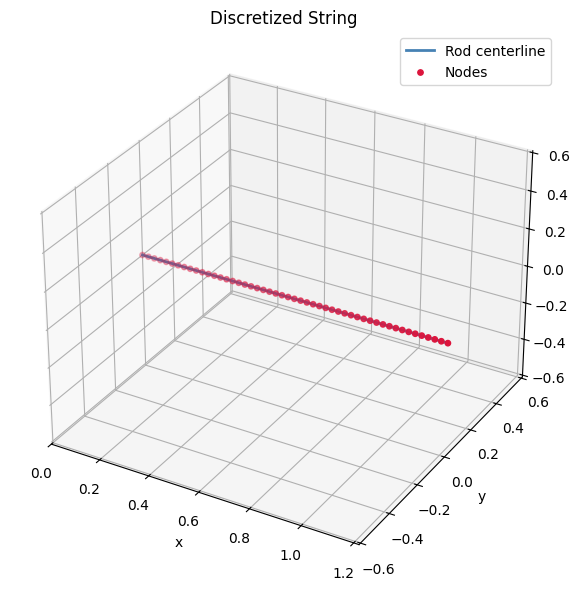

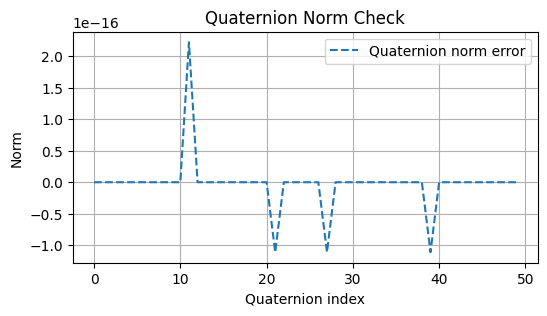

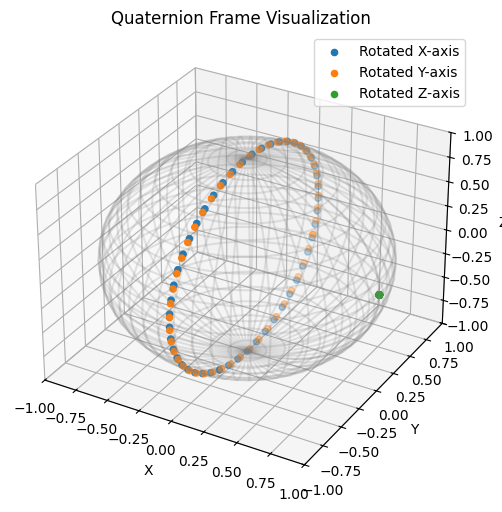

In [50]:
plot_string(reference_positions, nodes)
plot_edge_quaternions(edges)

In [54]:
sim = Simulation(
    nodes=nodes,
    edges=edges,
    hammer_weights=weights,
    oversampling_factor=oversampling_factor,
    chunk_size=chunk_size,
    dt=dt,
    dx=dl,
    mass=mass,
    stiffness_se = K_se,
    stiffness_bt = K_bt,
    inertia=inertia,
    clamp_offset=0,
    dampening=dampening,
)
 

sim.initialize()

Initializing simulation!


## Initial conditions

In [55]:
for f in ds_force:
    sim.hammer(10, f)

## Running the simulation

In [56]:
%%time

t2node_frames = list()
t2edge_frames = list()

for i in range(dispatches):
    sim.compute()
    n, e = sim.save()
    t2node_frames.extend(n)
    t2edge_frames.extend(e)

CPU times: user 3min 39s, sys: 1min 21s, total: 5min
Wall time: 3min 15s


#### Sanity checks

No NaNs found!


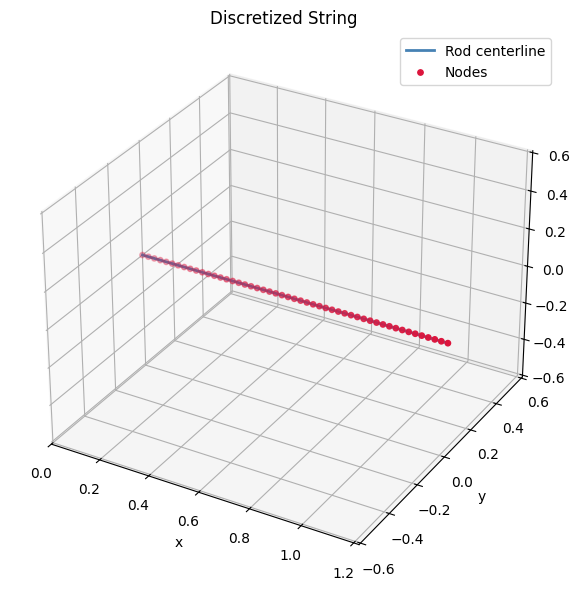

In [57]:
if any(np.isnan(node[0]).any() for node in t2node_frames[-1]):
    print("Some displacements are NaN; the dt is likely too small for the chosen dl!")
else:
    print("No NaNs found!")
    plot_string(reference_positions, t2node_frames[-1])



## Results

x Inharmonicity Coeff (B): 0.00e+00


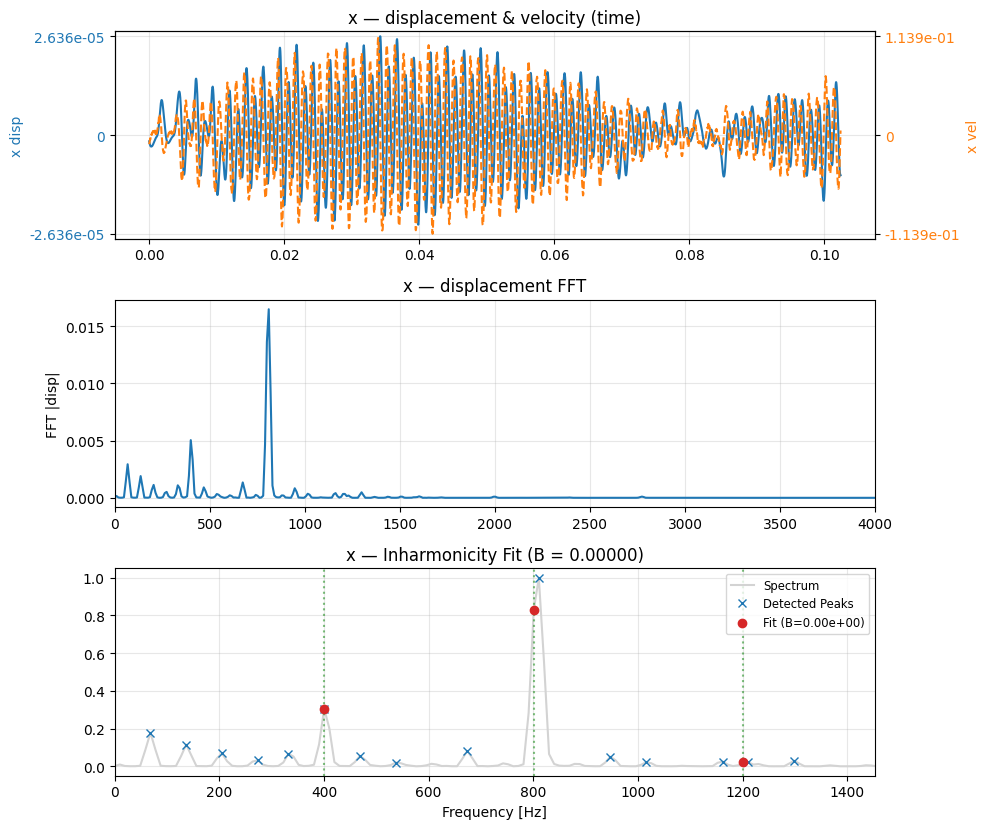

y Inharmonicity Coeff (B): 6.87e-05


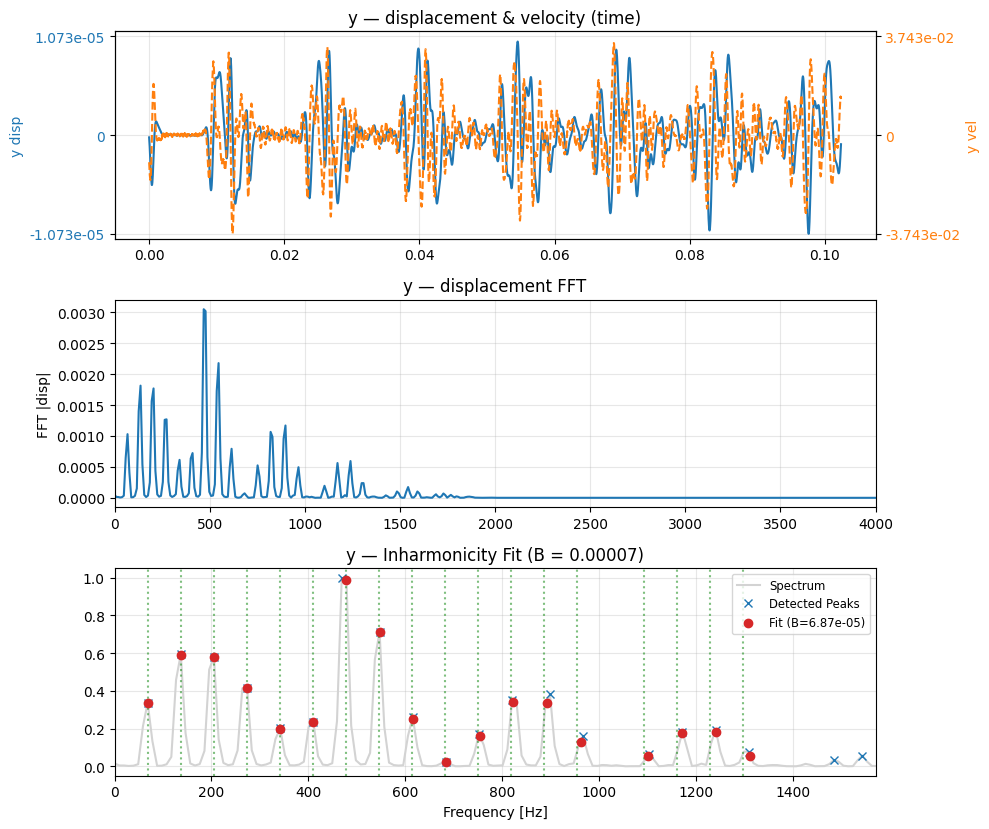

z Inharmonicity Coeff (B): 1.28e-04


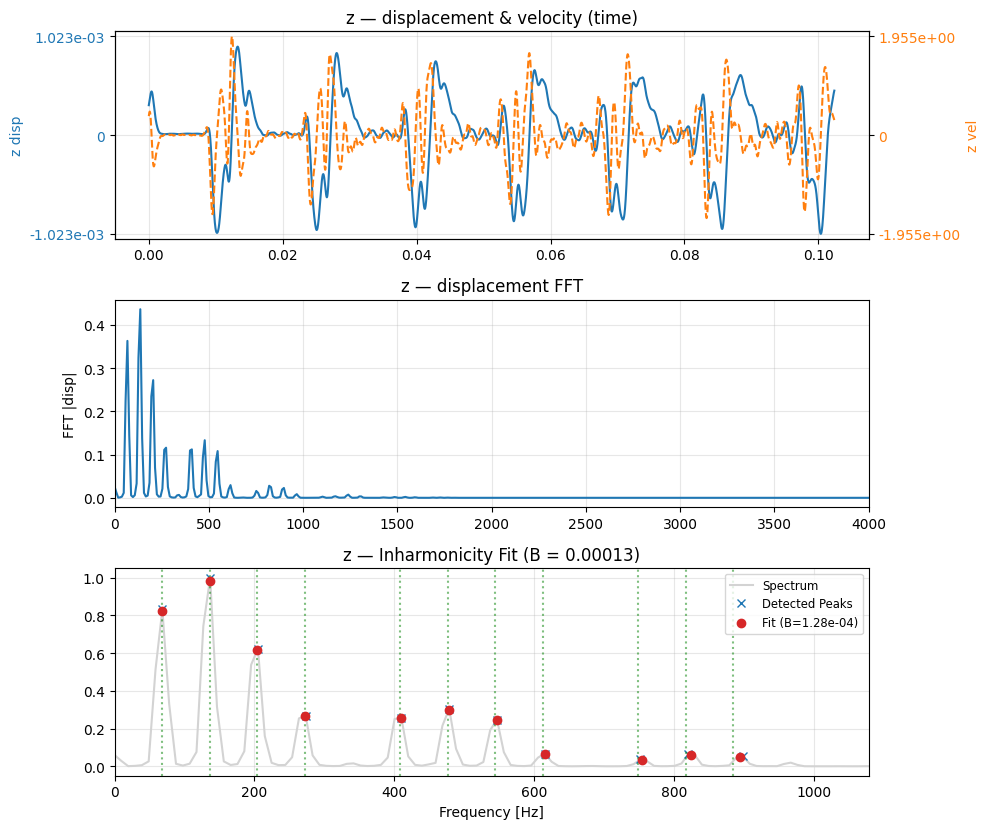

In [58]:
plot_node_pos_vel_moment_fft(t2node_frames, dt, oversampling_factor, cutoff=4000, windowing=True, node_index=20, save_output=True, prefix="three_twists")

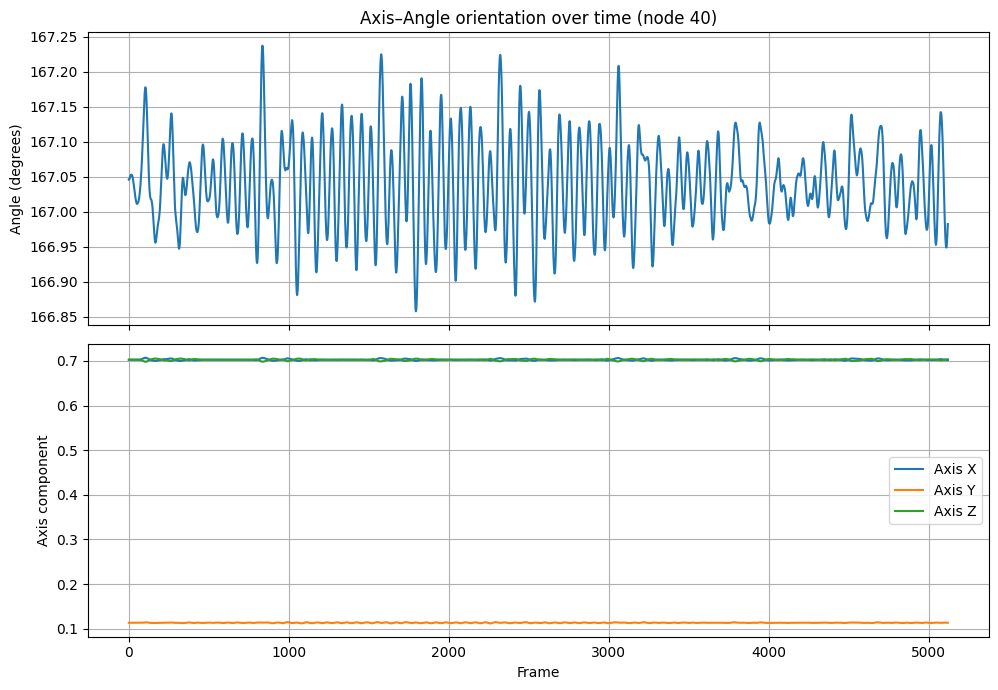

In [59]:
plot_axis_angle_over_time(t2edge_frames, node_index=40, components="xyz", save_output=True, prefix="three_twists")

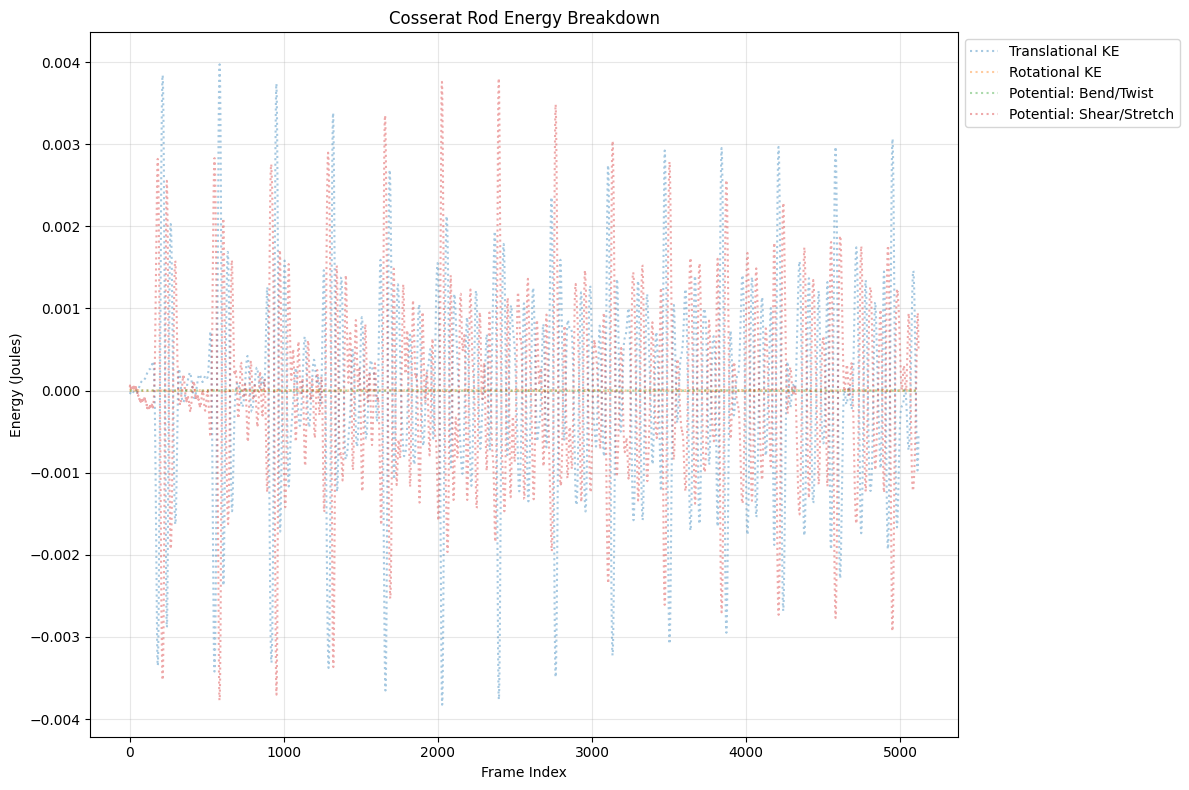

Total Energy Mean: 1.748858e-07 J
Energy Variation: 2.246984e-04 J


In [60]:
start, end = (0, len(node_frames))
plot_energies(t2node_frames[start:end], t2edge_frames[start:end], mass, inertia, K_se, K_bt, dl, show_totals=False, remove_offset=True, save_output=True, prefix="three_twists")

In [61]:
play_node_audio(t2node_frames, sample_rate, save_output=True, prefix="three_twists")

Output is less than 0.5 seconds long, omitting saving output


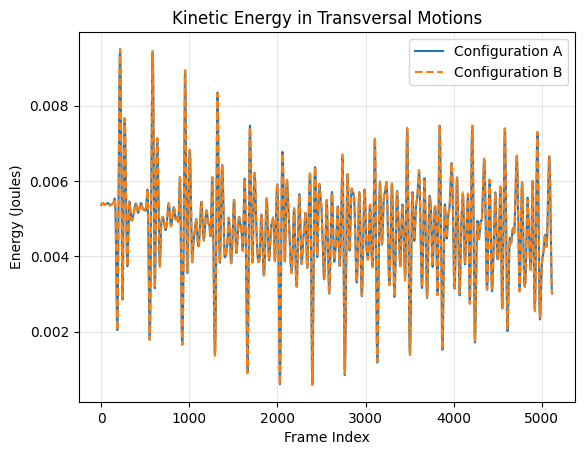

In [62]:
compare_T_yz(tnode_frames, t2node_frames, mass, save_output=True, prefix="one_twist_three_twists")